In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Part 1: Price Prediction

In [2]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [5]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [6]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [7]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [8]:
### try autoregressive RNN model
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
  
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [9]:
model = RNN(1, 5, 1, 1)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [12]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [13]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [14]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [15]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.4497, Test Loss: 2.2022
Epoch 10/200, Train Loss: 0.2964, Test Loss: 0.1888
Epoch 15/200, Train Loss: 0.1597, Test Loss: 0.6933
Epoch 20/200, Train Loss: 0.0934, Test Loss: 1.2970
Epoch 25/200, Train Loss: 0.0544, Test Loss: 0.5226
Epoch 30/200, Train Loss: 0.0139, Test Loss: 0.1473
Epoch 35/200, Train Loss: 0.0148, Test Loss: 0.0496
Epoch 40/200, Train Loss: 0.0084, Test Loss: 0.0418
Epoch 45/200, Train Loss: 0.0081, Test Loss: 0.0206
Epoch 50/200, Train Loss: 0.0062, Test Loss: 0.0172
Epoch 55/200, Train Loss: 0.0062, Test Loss: 0.0195
Epoch 60/200, Train Loss: 0.0055, Test Loss: 0.0235
Epoch 65/200, Train Loss: 0.0056, Test Loss: 0.0202
Epoch 70/200, Train Loss: 0.0055, Test Loss: 0.0152
Epoch 75/200, Train Loss: 0.0053, Test Loss: 0.0161
Epoch 80/200, Train Loss: 0.0053, Test Loss: 0.0174
Epoch 85/200, Train Loss: 0.0053, Test Loss: 0.0158
Epoch 90/200, Train Loss: 0.0053, Test Loss: 0.0166
Epoch 95/200, Train Loss: 0.0053, Test Loss: 0.0169
Epoch 100/200

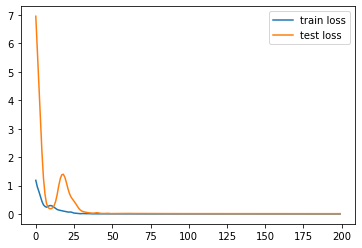

In [16]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

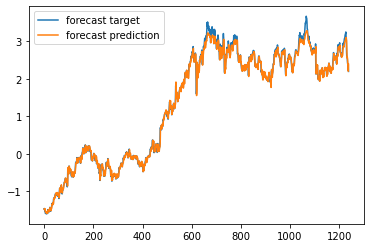

In [18]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [19]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

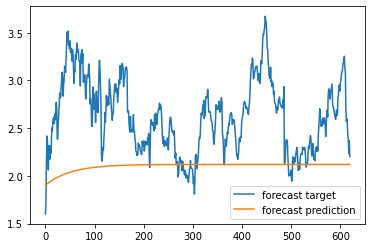

In [20]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 2: Returns

In [31]:
df["Return"] = df.close.pct_change()

In [32]:
df.head()

,date,open,high,low,close,volume,Name,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,-0.005015


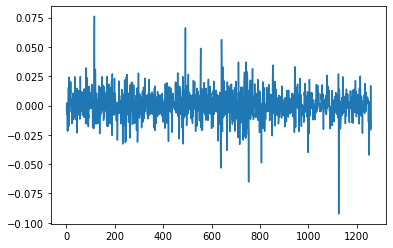

In [34]:
plt.plot(df.Return)
plt.show()

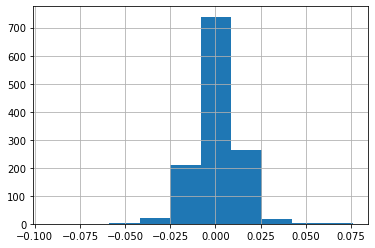

In [36]:
df.Return.hist()
plt.show()

In [41]:
series = df.Return.values[1:].reshape(-1, 1)

In [42]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [45]:
T = 20
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(series)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (1238, 20, 1), Y.shape: (1238, 1)


In [46]:
model = RNN(1, 5, 1, 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [49]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [50]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [51]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [52]:
train_losses, test_losses = full_gd(model, 
                                   criterion, 
                                   optimizer, 
                                   X_train, 
                                   y_train, 
                                   X_test, 
                                   y_test)

Epoch 5/200, Train Loss: 0.9937, Test Loss: 1.1269
Epoch 10/200, Train Loss: 0.9900, Test Loss: 1.1374
Epoch 15/200, Train Loss: 0.9878, Test Loss: 1.1363
Epoch 20/200, Train Loss: 0.9868, Test Loss: 1.1409
Epoch 25/200, Train Loss: 0.9857, Test Loss: 1.1416
Epoch 30/200, Train Loss: 0.9845, Test Loss: 1.1410
Epoch 35/200, Train Loss: 0.9835, Test Loss: 1.1408
Epoch 40/200, Train Loss: 0.9822, Test Loss: 1.1443
Epoch 45/200, Train Loss: 0.9807, Test Loss: 1.1477
Epoch 50/200, Train Loss: 0.9789, Test Loss: 1.1539
Epoch 55/200, Train Loss: 0.9770, Test Loss: 1.1572
Epoch 60/200, Train Loss: 0.9749, Test Loss: 1.1627
Epoch 65/200, Train Loss: 0.9725, Test Loss: 1.1683
Epoch 70/200, Train Loss: 0.9694, Test Loss: 1.1735
Epoch 75/200, Train Loss: 0.9652, Test Loss: 1.1792
Epoch 80/200, Train Loss: 0.9596, Test Loss: 1.1863
Epoch 85/200, Train Loss: 0.9526, Test Loss: 1.2006
Epoch 90/200, Train Loss: 0.9443, Test Loss: 1.2258
Epoch 95/200, Train Loss: 0.9353, Test Loss: 1.2548
Epoch 100/200

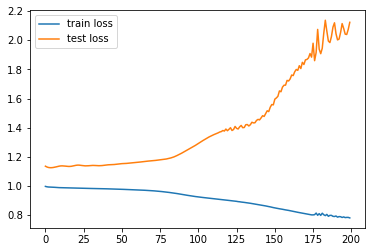

In [53]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [54]:
validation_target = Y
validation_predictions = []

i = 0
X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(-1, T, 1)
    p = model(input_)[0, 0].item()
    
    i += 1
    
    validation_predictions.append(p)

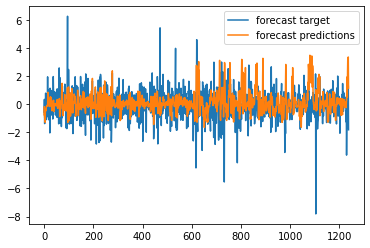

In [55]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
plt.show()

In [56]:
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)
while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(-1, T, 1)
    p = model(input_)
    
    validation_predictions.append(p[0, 0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

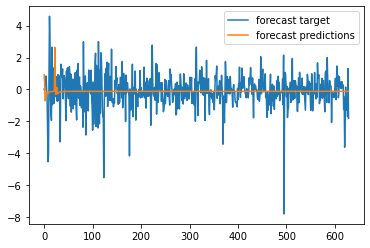

In [57]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
plt.show()

## Part 3: Binary Classification

In [79]:
input_data = df[["open", "high", "low", "close", "volume"]].values
targets = df["Return"].values

In [80]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [81]:
input_data.shape[1]

5

In [92]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [93]:
X_train = np.zeros((Ntrain, T, D))
y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t + T]
    y_train[t] = (targets[t + T] > 0)    

In [94]:
X_test = np.zeros((N - Ntrain, T, D))
y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t + T]
    y_test[u] = (targets[t + T] > 0)

In [95]:
model = RNN(5, 50, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [96]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [97]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [98]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [99]:
train_losses, test_losses = full_gd(model, 
                                   criterion, 
                                   optimizer, 
                                   X_train, 
                                   y_train, 
                                   X_test, 
                                   y_test, 
                                   epochs=300)

Epoch 5/300, Train Loss: 0.6917, Test Loss: 0.6925
Epoch 10/300, Train Loss: 0.6908, Test Loss: 0.6956
Epoch 15/300, Train Loss: 0.6878, Test Loss: 0.6956
Epoch 20/300, Train Loss: 0.6837, Test Loss: 0.6935
Epoch 25/300, Train Loss: 0.6780, Test Loss: 0.6927
Epoch 30/300, Train Loss: 0.6722, Test Loss: 0.7051
Epoch 35/300, Train Loss: 0.6646, Test Loss: 0.7032
Epoch 40/300, Train Loss: 0.6512, Test Loss: 0.7049
Epoch 45/300, Train Loss: 0.6395, Test Loss: 0.7119
Epoch 50/300, Train Loss: 0.6314, Test Loss: 0.7366
Epoch 55/300, Train Loss: 0.6201, Test Loss: 0.7095
Epoch 60/300, Train Loss: 0.5852, Test Loss: 0.7497
Epoch 65/300, Train Loss: 0.5754, Test Loss: 0.7759
Epoch 70/300, Train Loss: 0.5470, Test Loss: 0.7972
Epoch 75/300, Train Loss: 0.5004, Test Loss: 0.8034
Epoch 80/300, Train Loss: 0.4605, Test Loss: 0.8401
Epoch 85/300, Train Loss: 0.4612, Test Loss: 0.8253
Epoch 90/300, Train Loss: 0.4221, Test Loss: 0.8691
Epoch 95/300, Train Loss: 0.3994, Test Loss: 0.9041
Epoch 100/300

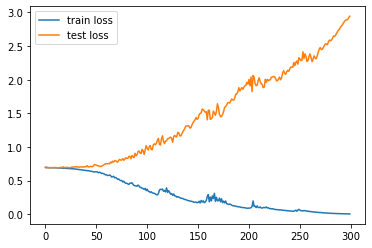

In [100]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [102]:
with torch.no_grad():
    p_train = model(X_train)
    p_train = (p_train.cpu().numpy() > 0)
    train_acc = np.mean(y_train.cpu().numpy() == p_train)
    
    p_test = model(X_test)
    p_test = (p_test.cpu().numpy() == p_test)
    test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"train acc: {train_acc:.4f}, test acc: {test_acc:.4f}")

train acc: 1.0000, test acc: 0.5146
